## Lambda2 criterion

The gradient velocity tensor $\mathbf{J}$:
\begin{equation*}
\mathbf{J} \equiv \Delta \vec{u} = \begin{vmatrix}
\frac{\partial u}{\partial x} &  \frac{\partial u}{\partial y} & \frac{\partial u}{\partial z} \\
\frac{\partial v}{\partial x} &  \frac{\partial v}{\partial y} & \frac{\partial v}{\partial z} \\
\frac{\partial w}{\partial x} &  \frac{\partial w}{\partial y} & \frac{\partial w}{\partial z} 
\end{vmatrix}
\end{equation*}
Where $\vec{u}$ is the velocity field. The gradient velocity tensor is then decomposed into its symmetric ($\mathbf{S}$) and antisymmetric ($\mathbf{\Omega}$) parts:
\begin{equation*}
\mathbf{S} = \frac{\mathbf{J}+\mathbf{J}^T}{2} \\
\mathbf{\Omega} = \frac{\mathbf{J}-\mathbf{J}^T}{2}
\end{equation*}
Next the three eigenvalues of $\mathbf{S}^2+\mathbf{\Omega}^2$ are calculated so that for each point in the velocity field $\vec{u}$ there are three corresponding eigenvalues: $\lambda_1, \lambda_2, \lambda_3$.  The eigenvalues are ordered in such a way that $\lambda_1 \geq \lambda_2 \geq \lambda_3$. A point in the velocity field is part of a vortex core only if at least two of its eigenvalues are negative i.e. if $\lambda_2 \lt 0$. This is what gave the Lambda2 method its name.

Src: https://en.wikipedia.org/wiki/Lambda2_method#cite_ref-2

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.linalg as la

%config InlineBackend.figure_format = 'retina'

The first step: create the vortex

In [14]:
from VortexModel import vsvm_pressure,vsvm_background_flow,vsvm # invoke the Very Simple Vortex Model

# Grid settings
N = 120
x_start, x_end = -2.0, 2.0
y_start, y_end = -2.0, 2.0

x = np.linspace(x_start, x_end, N)
y = np.linspace(y_start, y_end, N)

X, Y = np.meshgrid(x, y)

# Initial pressure filed
center = [ 0, 0 ] 
p = vsvm_pressure(X, Y, center=center)

# create an initial vortex (with dx = 20 km)
ui, vi = vsvm(p, 20000.)

# disturn the initial vortex
flow='flat'
umax=0
u, v = vsvm_background_flow(ui, vi, flow, umax)

# # plot the result (unnecessary)

# size=12

# fig = plt.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size-2))
# plt.xlabel('x', fontsize=16)
# plt.ylabel('y', fontsize=16)
# plt.xlim(x_start, x_end)
# plt.ylim(y_start, y_end)
# plt.grid(color='black', linestyle='--', linewidth=0.5)

# # plt.title("Couette background flow $U_{max}$ = 5 $ms^{-1}$")
# plt.title("{} background flow $U$ = {} $ms^{{-1}}$".format(flow,umax))


# plt.contourf(X, Y, np.sqrt(u**2+v**2), cmap='Blues') # 20, vmin=0,vmax=13, 
# cbar = plt.colorbar()
# cbar.ax.set_ylabel('velocity [m s-1]')

# plt.streamplot(X, Y, u, v, density=1, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
# plt.scatter(center[0], center[1], color='#CD2305', s=20, marker='x')
# plt.show()

The gradient velocity tensor function (sits in the VortexCriteria_Eulerian.py lib)

In [17]:
def gradient_velocity_tensor(u=0, v=0, w=0, dx=0, dy=0, dz=0):

    uarray = isinstance(u, np.ndarray)
    varray = isinstance(v, np.ndarray)
    warray = isinstance(w, np.ndarray)

    if uarray:
        dudx = np.gradient(u, dx, axis=1)
        dudy = np.gradient(u, dy, axis=0)
    if varray:
        dvdx = np.gradient(v, dx, axis=1)
        dvdy = np.gradient(v, dy, axis=0)
    if warray:
        dudz = np.gradient(u, dz, axis=0)
        dvdz = np.gradient(v, dz, axis=0)
        dwdx = np.gradient(w, dx, axis=1)
        dwdy = np.gradient(w, dy, axis=0)
        dwdz = np.gradient(w, dz, axis=0)

    if warray:
        res = np.full((u.shape[0], u.shape[1], u.shape[2], 3, 3), -999.)
        res[:, :, :, 0, 0] = dudx
        res[:, :, :, 0, 1] = dudy
        res[:, :, :, 0, 2] = dudz
        res[:, :, :, 1, 0] = dvdx
        res[:, :, :, 1, 1] = dvdy
        res[:, :, :, 1, 2] = dvdz
        res[:, :, :, 3, 0] = dwdx
        res[:, :, :, 3, 1] = dwdy
        res[:, :, :, 3, 2] = dwdz
    else:
        res = np.full((u.shape[0], u.shape[1], 2, 2), -999.)
        res[:, :, 0, 0] = dudx
        res[:, :, 0, 1] = dudy
        res[:, :, 1, 0] = dvdx
        res[:, :, 1, 1] = dvdy

    return res


Compute the gradient velocity tensor ($\mathbf{J} \equiv \Delta \vec{u}$)

In [29]:
tgradv = gradient_velocity_tensor(u=u, v=v, w=0, dx=20000, dy=20000, dz=0)

Transpose it $(\mathbf{J}^T)$

In [30]:
tgradvt = np.swapaxes(tgradv, 2, 3)

Get its symmetric ($\mathbf{S}=\frac{\mathbf{J}+\mathbf{J}^T}{2}$) and antisymmetric ($\mathbf{\Omega} = \frac{\mathbf{J}-\mathbf{J}^T}{2}$) parts

In [31]:
sym = 0.5*(tgradv + tgradvt)
omg = 0.5*(tgradv - tgradvt)

Compute $\mathbf{S}^2+\mathbf{\Omega}^2$

In [37]:
s2 = (0.5*(tgradv + tgradvt))**2
o2 = (0.5*(tgradv - tgradvt))**2
A = s2 + o2

Compute three eigenvalues of $\mathbf{S}^2+\mathbf{\Omega}^2$ 

In [60]:
L2 = np.full( (N,N), 999. )
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        L2[i,j] = np.real(np.min(la.eigvals(A[i,j,:,:])))


# L = np.real(la.eigvals(A[50,50,:,:]))

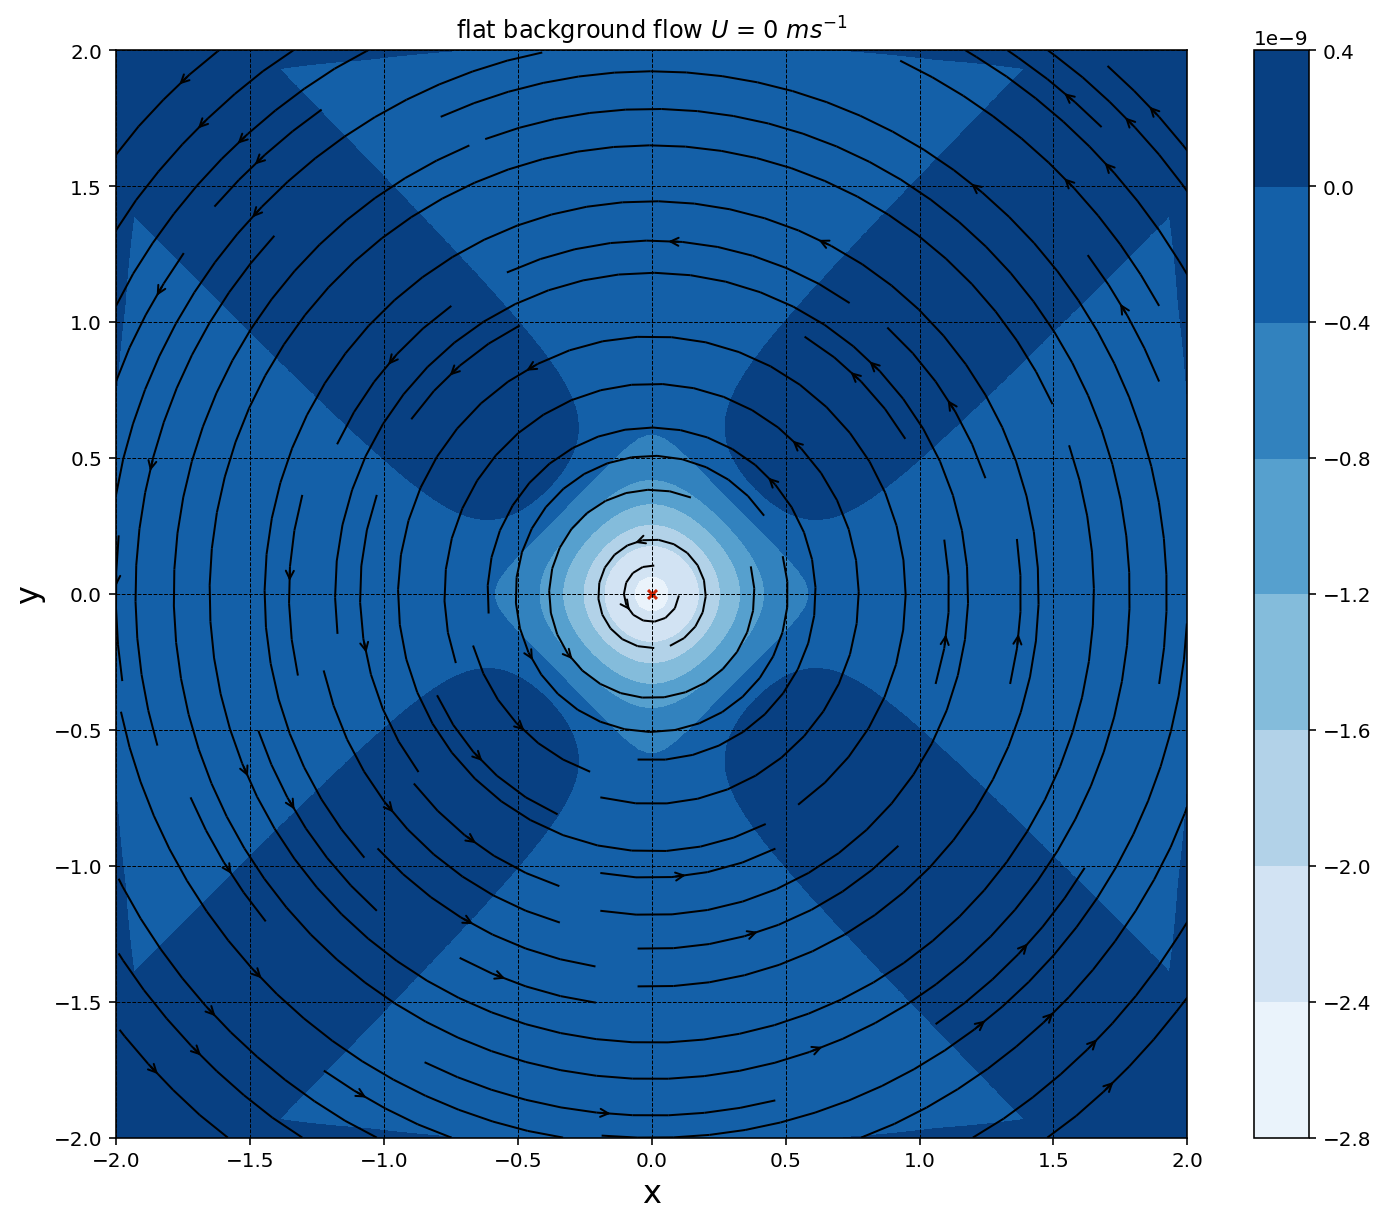

In [64]:
# plot the result (unnecessary)

size=12

fig = plt.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size-2))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.grid(color='black', linestyle='--', linewidth=0.5)

# plt.title("Couette background flow $U_{max}$ = 5 $ms^{-1}$")
plt.title("{} background flow $U$ = {} $ms^{{-1}}$".format(flow,umax))


plt.contourf(X, Y, L2, cmap='Blues') # 20, vmin=0,vmax=13, 
cbar = plt.colorbar()
# cbar.ax.set_ylabel('velocity [m s-1]')

plt.streamplot(X, Y, u, v, density=1, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
plt.scatter(center[0], center[1], color='#CD2305', s=20, marker='x')
plt.show()